# KL-Divergence Filter

In [1]:
import numpy as np
from scipy import ndimage, stats, special

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In this notebook we will test out a filter for postage stamps that uses the [KL-Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to determine how alike the object in the postage stamp is to a model Gaussian distribution.

## Create base distribution for comparison

In [2]:
central_source = np.zeros((21, 21))

In [3]:
central_source[10, 10] = 1.0

In [4]:
gaussian_test = ndimage.gaussian_filter(central_source, 1.4)

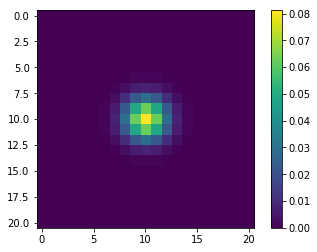

In [5]:
imshow(gaussian_test)
colorbar()

## Run some basic tests

The function we are going to use for this filter is the relative entropy function from scipy: [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html#scipy.special.rel_entr)

### Test 1: Same distribution
The KL Divergence should be 0 when the function is compared with itself.

In [6]:
from scipy.special import rel_entr

In [7]:
kl_div_same_dist = np.sum(rel_entr(gaussian_test, gaussian_test))
print("The KL Divergence of the test Gaussian with itself is: {}".format(kl_div_same_dist))

The KL Divergence of the test Gaussian with itself is: 0.0


### Test 2: Slightly Different Gaussians

These should be numbers greater than 0.

#### 2.1: Off-center Gaussian

Let's start with a Gaussian with the same width as the test Gaussian but off center by a couple pixels in one direction.

In [8]:
off_center_source = np.zeros((21, 21))
off_center_source[8, 10] = 1.0
gaussian_off_cent = ndimage.gaussian_filter(off_center_source, 1.4)

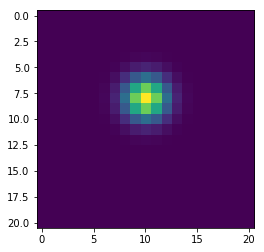

In [9]:
plt.imshow(gaussian_off_cent)

In [10]:
# We add a very small offset from 0 to avoid issues in the KL-div calculation
kl_div_off_center_dist = np.nansum(rel_entr(gaussian_test + 1e-12, gaussian_off_cent + 1e-12))
print("The KL Divergence of the test Gaussian with the offset Gaussian is: {}".format(kl_div_off_center_dist))

The KL Divergence of the test Gaussian with the offset Gaussian is: 1.0265198098645072


#### 2.2 Wider Gaussian

Here we use a Gaussian with double the sigma.

In [11]:
gaussian_doublewide = ndimage.gaussian_filter(central_source, 2.8)

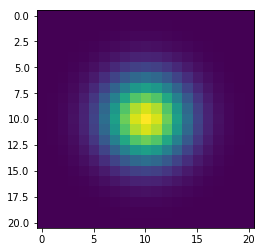

In [12]:
plt.imshow(gaussian_doublewide)

In [13]:
# We add a very small offset from 0 to avoid issues in the KL-div calculation
kl_div_doublewide_dist = np.nansum(rel_entr(gaussian_test + 1e-12, gaussian_doublewide + 1e-12))
print("The KL Divergence of the test Gaussian with the wider Gaussian is: {}".format(kl_div_doublewide_dist))

The KL Divergence of the test Gaussian with the wider Gaussian is: 0.6362651164616075


### Test 3: Poisson Noise

Above we saw results ~1 or less when comparing different distributions to our test Gaussian. Here we will test against Poisson noise and expect to see that the results are higher than the results in test 2.

In [14]:
poisson_noise = np.random.RandomState(42).poisson(100, size=(21, 21))
poisson_noise = poisson_noise / np.sum(poisson_noise)

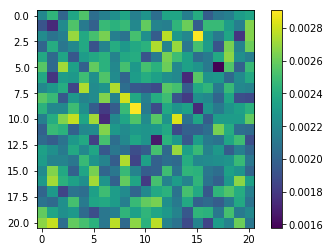

In [15]:
plt.imshow(poisson_noise)
plt.colorbar()

In [16]:
# We add a very small offset from 0 to avoid issues in the KL-div calculation
kl_div_poisson_dist = np.nansum(rel_entr(gaussian_test + 1e-12, poisson_noise + 1e-12))
print("The KL Divergence of the test Gaussian with the Poisson noise is: {}".format(kl_div_poisson_dist))

The KL Divergence of the test Gaussian with the Poisson noise is: 2.5696770438060157


As expected we see that the KL-divergence when comparing to random noise is much higher than the Gaussian distributions which are similar but still different to our test distribution.

Now that we have some evidence that this test could work, let's apply it to our false positive training set.

## Apply to KBMOD False Positives

We load the new training data created by Hayden.

In [17]:
full_false = np.load("/epyc/users/smotherh/kbmod_epyc/notebooks/normed_individual_false.npy")

In [18]:
keep_idx = []
idx = 0
for f_im in full_false:
    if np.isnan(f_im[0][0]):
        idx += 1
        continue
    else:
        keep_idx.append(idx)
        idx += 1
full_false = full_false[keep_idx]

In [19]:
full_true = np.load("/epyc/users/smotherh/kbmod_epyc/notebooks/normed_individual_simulated.npy")

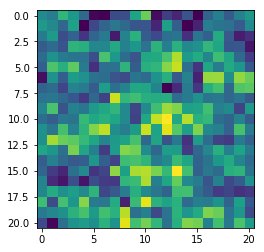

In [20]:
imshow(full_false[0].reshape(21, 21))

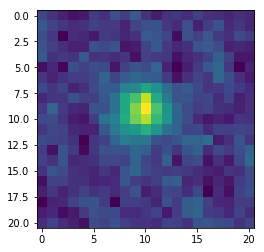

In [21]:
imshow(full_true[0].reshape(21, 21))

Reshape all the arrays into their two-dimensional postage stamp form. Then add an offset to them so they all have a minimum value just above 0. When doing the relative entropy calculation we also normalize the stamps.

In [22]:
false_values = []
for f_im in full_false:
    false_stamp = f_im.reshape(21, 21)
    false_stamp -= np.min(false_stamp)
    false_stamp += 1e-12
    # false_kl = special.kl_div(gaussian_test, (false_stamp/np.sum(false_stamp)))
    false_kl = special.rel_entr(gaussian_test, (false_stamp / np.sum(false_stamp)))
    false_values.append(np.nansum(false_kl))
false_values = np.array(false_values)

In [23]:
true_values = []
for t_im in full_true:
    true_stamp = t_im.reshape(21, 21)
    true_stamp -= np.min(true_stamp)
    true_stamp += 1e-12
    # true_kl = special.kl_div(gaussian_test, (true_stamp/np.sum(true_stamp)))
    true_kl = special.rel_entr(gaussian_test, (true_stamp / np.sum(true_stamp)))
    true_values.append(np.nansum(true_kl))
true_values = np.array(true_values)

In [24]:
len(full_false)

99935

In [25]:
len(false_values), len(true_values)

(99935, 44950)

Text(0,0.5,'Density')

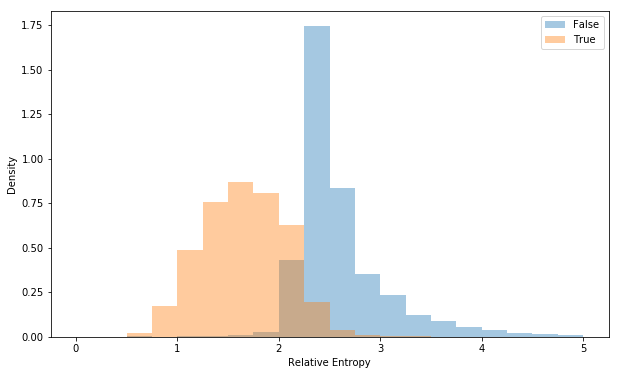

In [26]:
fig = plt.figure(figsize=(10, 6))
n, bins, _ = hist(false_values, alpha=0.4, label="False", bins=20, range=(0, 5), density=True)
hist(true_values, alpha=0.4, label="True", bins=bins, density=True)
legend()
xlabel("Relative Entropy")
ylabel("Density")

This looks really promising! There is a clear separation between the peaks for False objects and True sources. There is an area of overlap in the results. To see how well we do when training a classifier to decide True/False when looking at a postage stamps we'll train a logistic regression next.

### Optimize separation value

First break into training/test sets.

In [27]:
rand_state = np.random.RandomState(24)

false_selection = rand_state.choice(np.arange(len(false_values)), size=40000, replace=False)
train_false, test_false = false_values[false_selection[:30000]], false_values[false_selection[30000:]]

true_selection = rand_state.choice(np.arange(len(true_values)), size=40000, replace=False)
train_true, test_true = true_values[true_selection[:30000]], true_values[true_selection[30000:]]

train_data = np.array(train_false)
train_labels = np.zeros(len(train_false))
train_data = np.append(train_data, train_true)
train_labels = np.append(train_labels, np.ones(len(train_true)))

train_idx = np.arange(len(train_data))
rand_state.shuffle(train_idx)

train_data = train_data[train_idx]
train_labels = train_labels[train_idx]

test_data = np.array(test_false)
test_labels = np.zeros(len(test_false))
test_data = np.append(test_data, test_true)
test_labels = np.append(test_labels, np.ones(len(test_true)))

We'll use the `LogisticRegression` classifier from scikit-learn to learn a boundary on the relative entropy value.

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
classifier = LogisticRegression()

In [30]:
classifier.fit(train_data.reshape(-1, 1), train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

(0, 5)

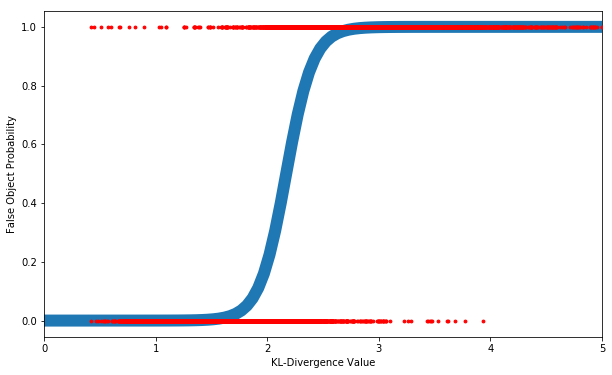

In [31]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 5, 100), classifier.predict_proba(np.linspace(0, 5, 100).reshape(-1, 1))[:, 0], lw=12)
plt.scatter(test_data, np.abs(1 - test_labels), c="r", s=8, zorder=10)
plt.ylabel("False Object Probability")
plt.xlabel("KL-Divergence Value")
plt.xlim(0, 5)

In [32]:
test_results = classifier.predict(test_data.reshape(-1, 1))
test_prob = classifier.predict_proba(test_data.reshape(-1, 1))

In [33]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

true_positive_idx = []
false_positive_idx = []
true_negative_idx = []
false_negative_idx = []

idx = 0
for test_label, test_result in zip(test_labels, test_results):
    if test_label == 1 and test_result == 1:
        true_positive += 1
        true_positive_idx.append(idx)
    elif test_label == 1 and test_result == 0:
        false_negative += 1
        false_negative_idx.append(idx)
    elif test_label == 0 and test_result == 1:
        false_positive += 1
        false_positive_idx.append(idx)
    elif test_label == 0 and test_result == 0:
        true_negative += 1
        true_negative_idx.append(idx)
    else:
        print("error")

    idx += 1

In [34]:
matrix = [[true_positive, false_positive], [false_negative, true_negative]]

In [35]:
true_positive

8959

In [36]:
matrix

[[8959, 511], [1041, 9489]]

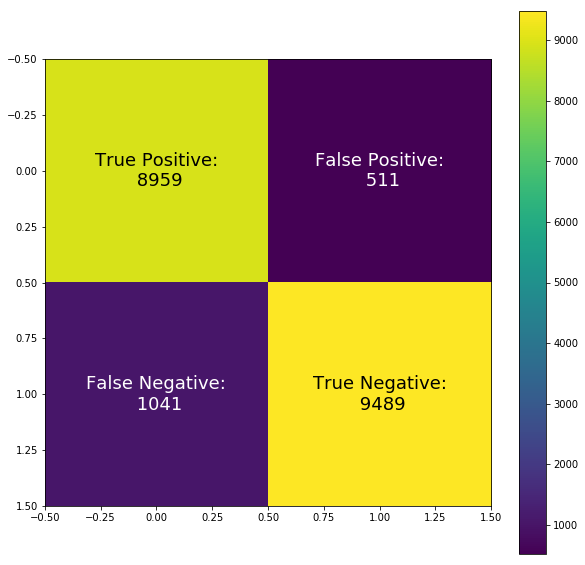

In [37]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.text(
    -0.0,
    0,
    "True Positive:\n {}".format(true_positive),
    horizontalalignment="center",
    verticalalignment="center",
    size=18,
    color="k",
)
plt.text(
    1.0,
    1.0,
    "True Negative:\n {}".format(true_negative),
    horizontalalignment="center",
    verticalalignment="center",
    size=18,
    color="k",
)
plt.text(
    -0.0,
    1,
    "False Negative:\n {}".format(false_negative),
    horizontalalignment="center",
    verticalalignment="center",
    size=18,
    color="w",
)
plt.text(
    1.0,
    0.0,
    "False Positive:\n {}".format(false_positive),
    horizontalalignment="center",
    verticalalignment="center",
    size=18,
    color="w",
)
plt.colorbar()

### What do the false positives look like?

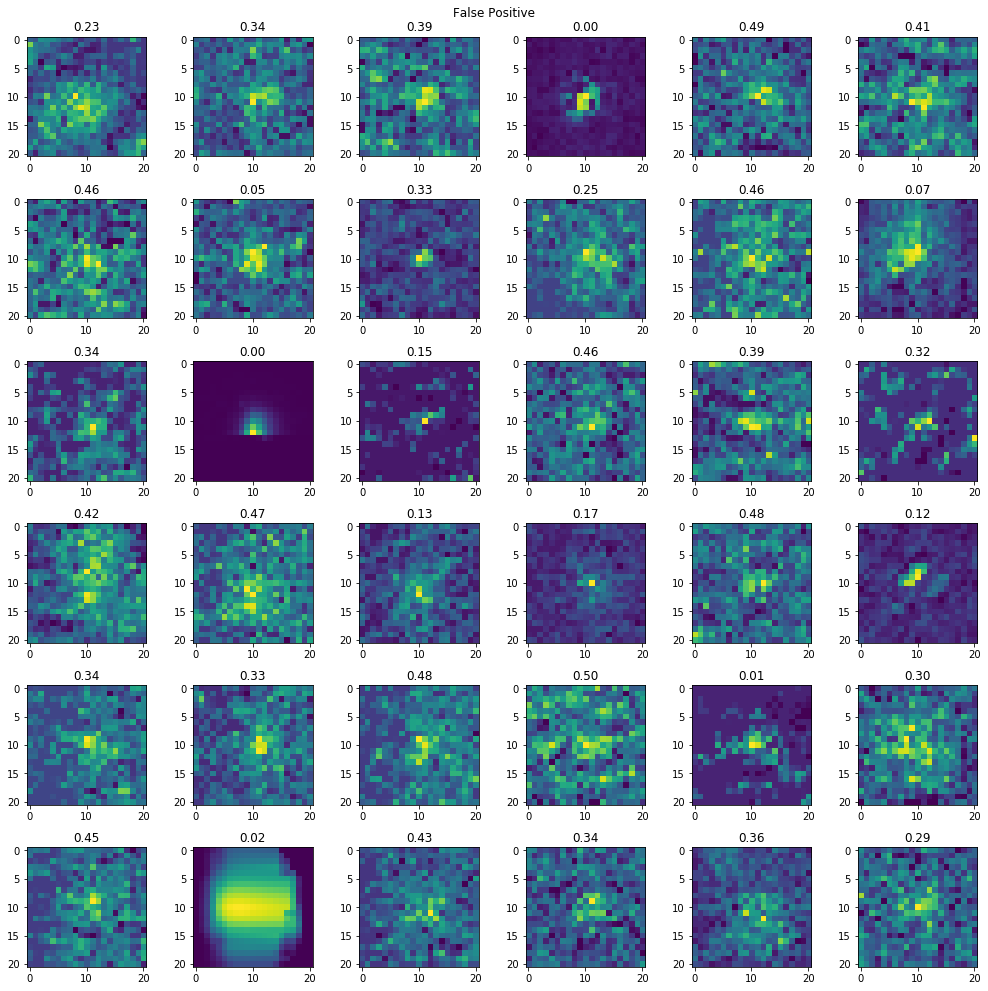

In [38]:
fig = plt.figure(figsize=(14, 14))
for i in range(36):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(full_false[false_selection[30000 + false_positive_idx[i]]].reshape(21, 21))
    plt.title("{:.2f}".format(test_prob[false_positive_idx[i]][0]))
plt.tight_layout()
plt.suptitle("False Positive")
plt.subplots_adjust(top=0.95)

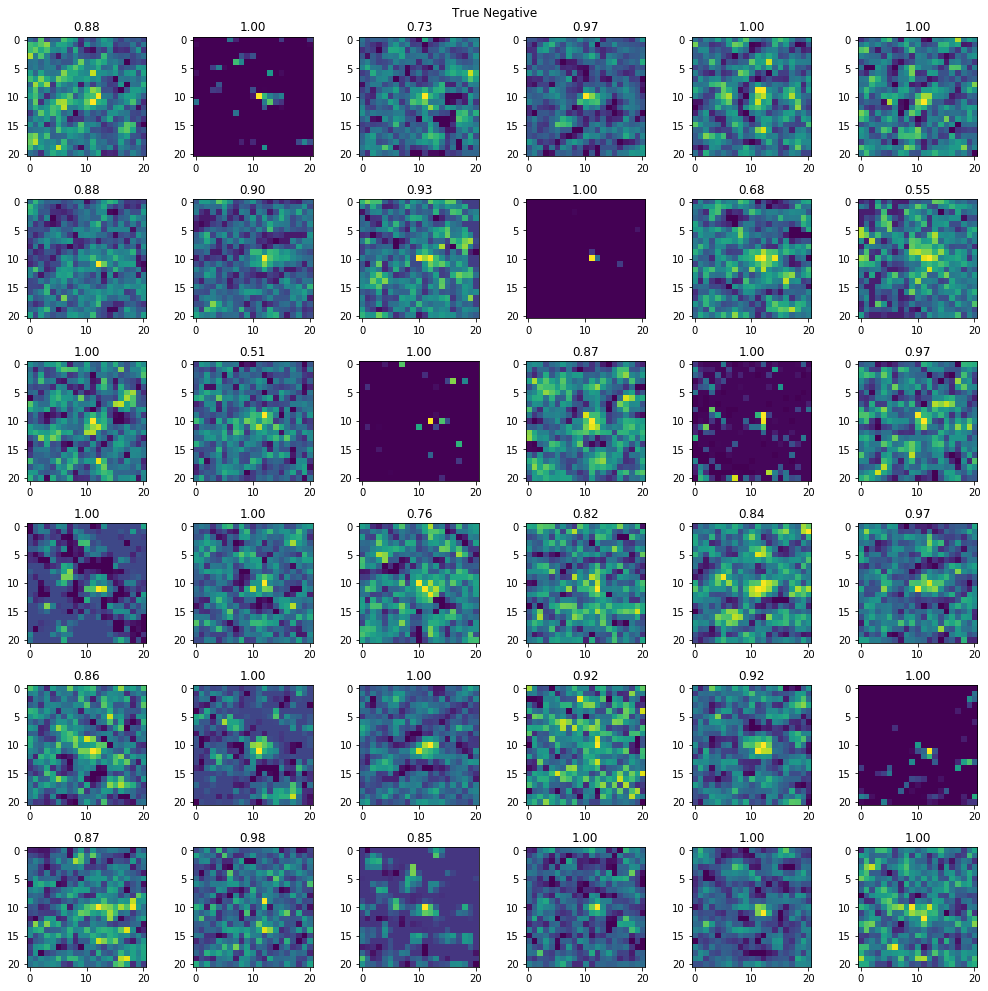

In [39]:
fig = plt.figure(figsize=(14, 14))
for i in range(36):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(full_false[false_selection[30000 + true_negative_idx[i]]].reshape(21, 21))
    plt.title("{:.2f}".format(test_prob[true_negative_idx[i]][0]))
plt.tight_layout()
plt.suptitle("True Negative")
plt.subplots_adjust(top=0.95)

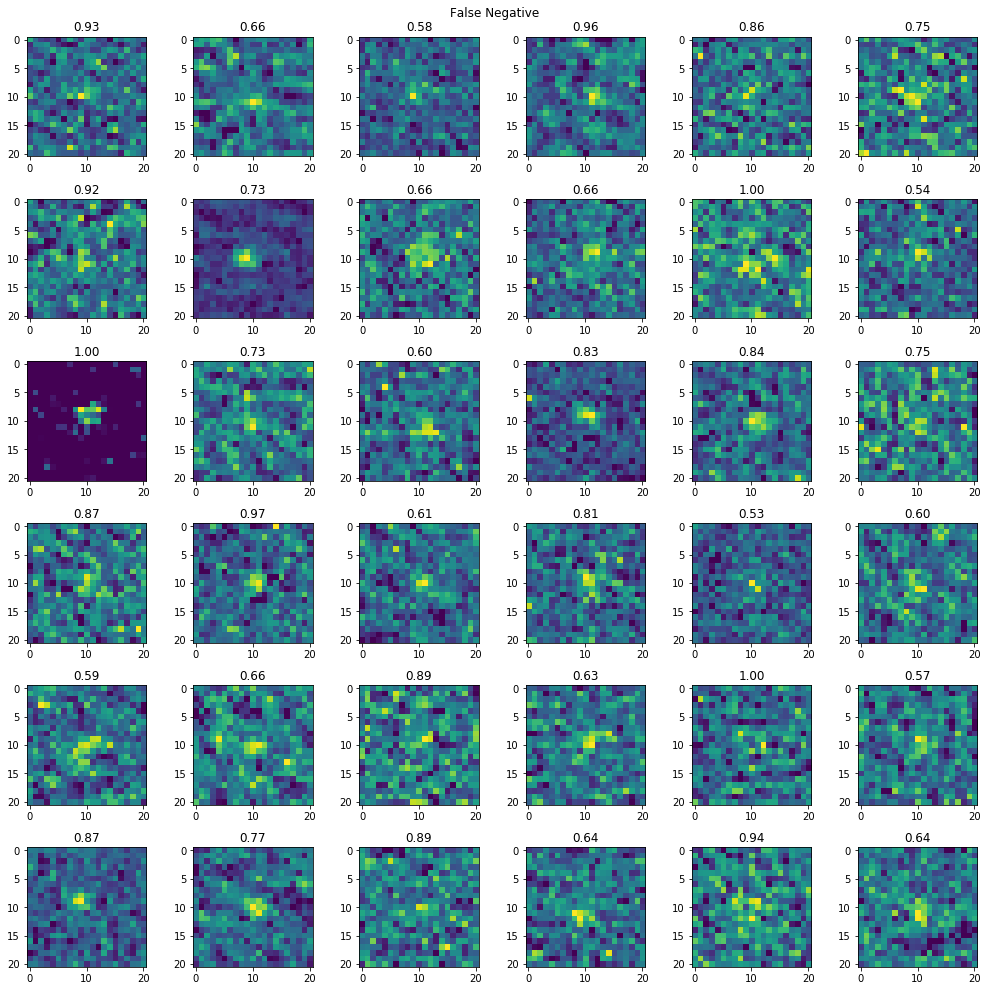

In [40]:
fig = plt.figure(figsize=(14, 14))
for i in range(36):
    fig.add_subplot(6, 6, i + 1)
    plt.imshow(full_true[true_selection[30000 + false_negative_idx[i] - 10000]].reshape(21, 21))
    plt.title("{:.2f}".format(test_prob[false_negative_idx[i]][0]))
plt.tight_layout()
plt.suptitle("False Negative")
plt.subplots_adjust(top=0.95)

In [41]:
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

In [42]:
print("Accuracy = {:.2f}%".format(100 * accuracy))

Accuracy = 92.24%


### Using "real" false positives

This section uses a new set of data where the true sources are verified asteroids found in the Lori Allen data. The false sources are actual false positives from KBMOD searches.

**We use the training from the synthetic training set in the first part of the notebook and apply it here to the "real" data.**

In [43]:
real_fake = np.load("/epyc/users/smotherh/kbmod_epyc/notebooks/normed_individual_real_false_positives.npy")

In [44]:
real_true = np.load("/epyc/users/smotherh/kbmod_epyc/notebooks/normed_individual_real.npy")

In [45]:
real_true_values = []
for t_im in real_true:
    true_stamp = t_im.reshape(21, 21)
    true_stamp -= np.min(true_stamp)
    true_stamp += 1e-12
    # true_kl = special.kl_div(gaussian_test, (true_stamp/np.sum(true_stamp)))
    true_kl = special.rel_entr(gaussian_test, (true_stamp / np.sum(true_stamp)))
    real_true_values.append(np.nansum(true_kl))
real_true_values = np.array(real_true_values)

In [46]:
%%time
real_fake_values = []
for t_im in real_fake:
    fake_stamp = t_im.reshape(21, 21)
    fake_stamp -= np.min(fake_stamp)
    fake_stamp += 1e-12
    # true_kl = special.kl_div(gaussian_test, (true_stamp/np.sum(true_stamp)))
    fake_kl = special.rel_entr(gaussian_test, (fake_stamp / np.sum(fake_stamp)))
    real_fake_values.append(np.nansum(fake_kl))
real_fake_values = np.array(real_fake_values)

CPU times: user 1.79 s, sys: 434 ms, total: 2.22 s
Wall time: 1.87 s


In [47]:
real_true_results = classifier.predict(real_true_values.reshape(-1, 1))
real_true_prob = classifier.predict_proba(real_true_values.reshape(-1, 1))

In [48]:
%%time
real_fake_results = classifier.predict(real_fake_values.reshape(-1, 1))
real_fake_prob = classifier.predict_proba(real_fake_values.reshape(-1, 1))

CPU times: user 44.5 ms, sys: 107 ms, total: 151 ms
Wall time: 2.94 ms


Text(0,0.5,'Count')

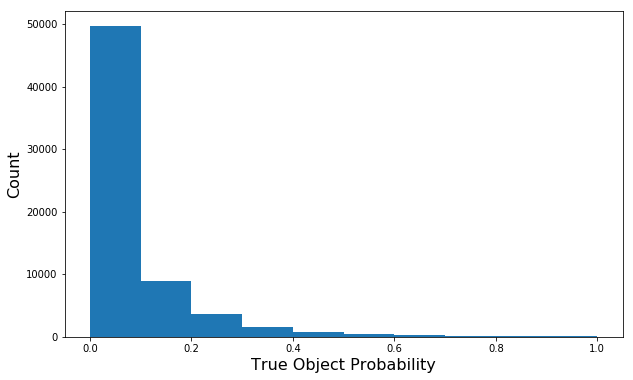

In [49]:
fig = figure(figsize=(10, 6))
hist(real_fake_prob[:, 1])
xlabel("True Object Probability", size=16)
ylabel("Count", size=16)

In [50]:
# Fraction of false positives correctly classified at 0.5 level
(len(real_fake_results) - np.sum(real_fake_results)) / len(real_fake_results)

0.9837447963524909

In [51]:
# Fraction of True Objects correctly classified at 0.5 level
np.sum(real_true_results) / len(real_true_results)

0.7857142857142857

In [52]:
real_true_results[:20]

array([1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.])

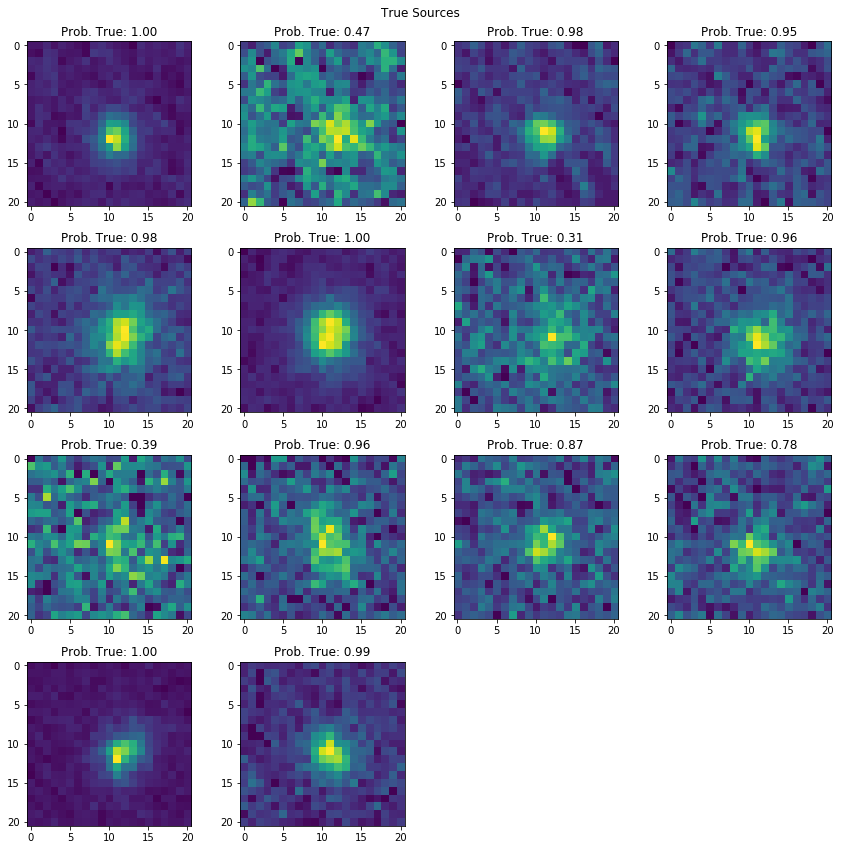

In [53]:
fig = figure(figsize(12, 12))
for i in range(len(real_true)):
    fig.add_subplot(4, 4, i + 1)
    imshow(real_true[i].reshape(21, 21))
    title("Prob. True: {:.2f}".format(real_true_prob[i][1]))
plt.tight_layout()
plt.suptitle("True Sources")
plt.subplots_adjust(top=0.94)

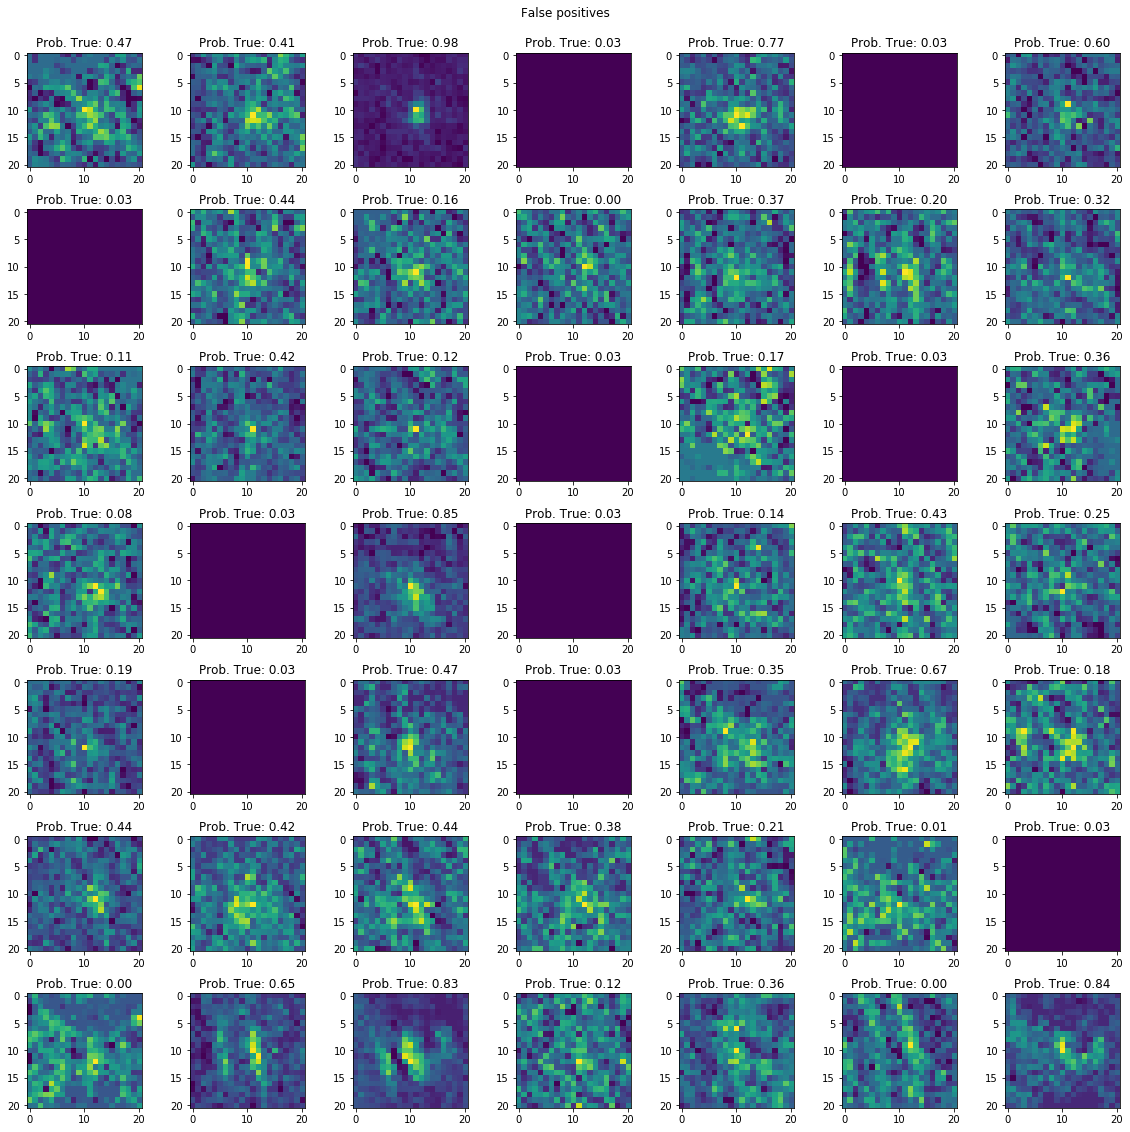

In [54]:
fig = figure(figsize(16, 16))
for i in range(49):
    fig.add_subplot(7, 7, i + 1)
    imshow(real_fake[i].reshape(21, 21))
    title("Prob. True: {:.2f}".format(real_fake_prob[i][1]))
plt.tight_layout()
plt.suptitle("False positives")
plt.subplots_adjust(top=0.94)

In [55]:
misclass = np.where(real_fake_prob[:, 1] > 0.95)

In [56]:
len(misclass[0])

104

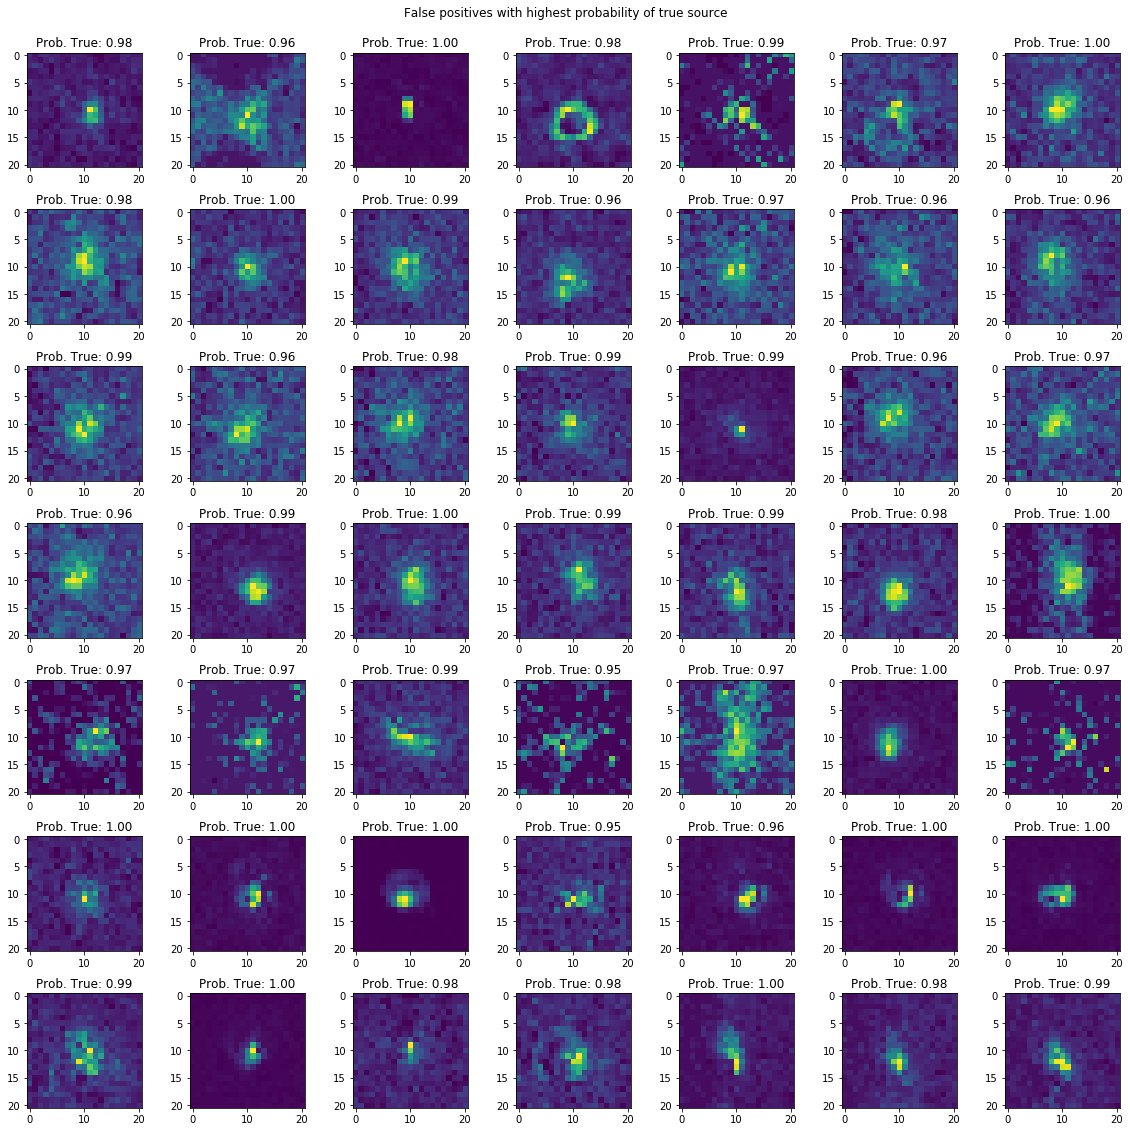

In [57]:
fig = figure(figsize(16, 16))
for i, idx in list(enumerate(misclass[0]))[:49]:
    fig.add_subplot(7, 7, i + 1)
    imshow(real_fake[idx].reshape(21, 21))
    title("Prob. True: {:.2f}".format(real_fake_prob[idx][1]))
plt.tight_layout()
plt.suptitle("False positives with highest probability of true source")
plt.subplots_adjust(top=0.94)